# **Pothole Detection using YoloV8**
In this project we will try to detect potholes from the images of roads using a computer vision technique known as Object Detection, a technique used to locating instances and objects within an image or videos.
The algorithm that we are going to use is known as YOLO or You Only Look Once that used simple convolutional neural networks to detect object in images

# Install essential modules

In [1]:
!pip install ultralytics
!pip install roboflow # will be used to import data

In [2]:
!nvidia-smi


Wed Dec 20 17:14:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import libraries and Dependencies

In [38]:
import os
import random
import glob
import pathlib
import matplotlib.pyplot as plt
import cv2
import PIL
from IPython.display import display,Image

from ultralytics import YOLO
from google.colab.patches import cv2_imshow

In [4]:
# get the dataset from roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="API-KEY")
project = rf.workspace("pothole-detection-xldvi").project("pothole-ykhai")
dataset = project.version(9).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.228, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Pothole-9 in yolov8:: 100%|██████████| 5976/5976 [00:03<00:00, 1623.87it/s]


# Exploratory Data Analysis

In [5]:
# shape of train images
img = cv2.imread('/content/Pothole-9/train/images/2_jpeg.rf.2fcdc787a9a19e7c4f378b767ede228f.jpg')
print('Shape of train images: ',img.shape)

Shape of train images:  (640, 640, 3)


In [10]:
# print the number of images in train test and validation set
print("Number of train images: ",len(os.listdir('/content/Pothole-9/train/images')))
print("Number of test images: ",len(os.listdir('/content/Pothole-9/test/images')))
print("Number of validation images: ",len(os.listdir('/content/Pothole-9/valid/images')))


Number of train images:  2647
Number of test images:  123
Number of validation images:  212


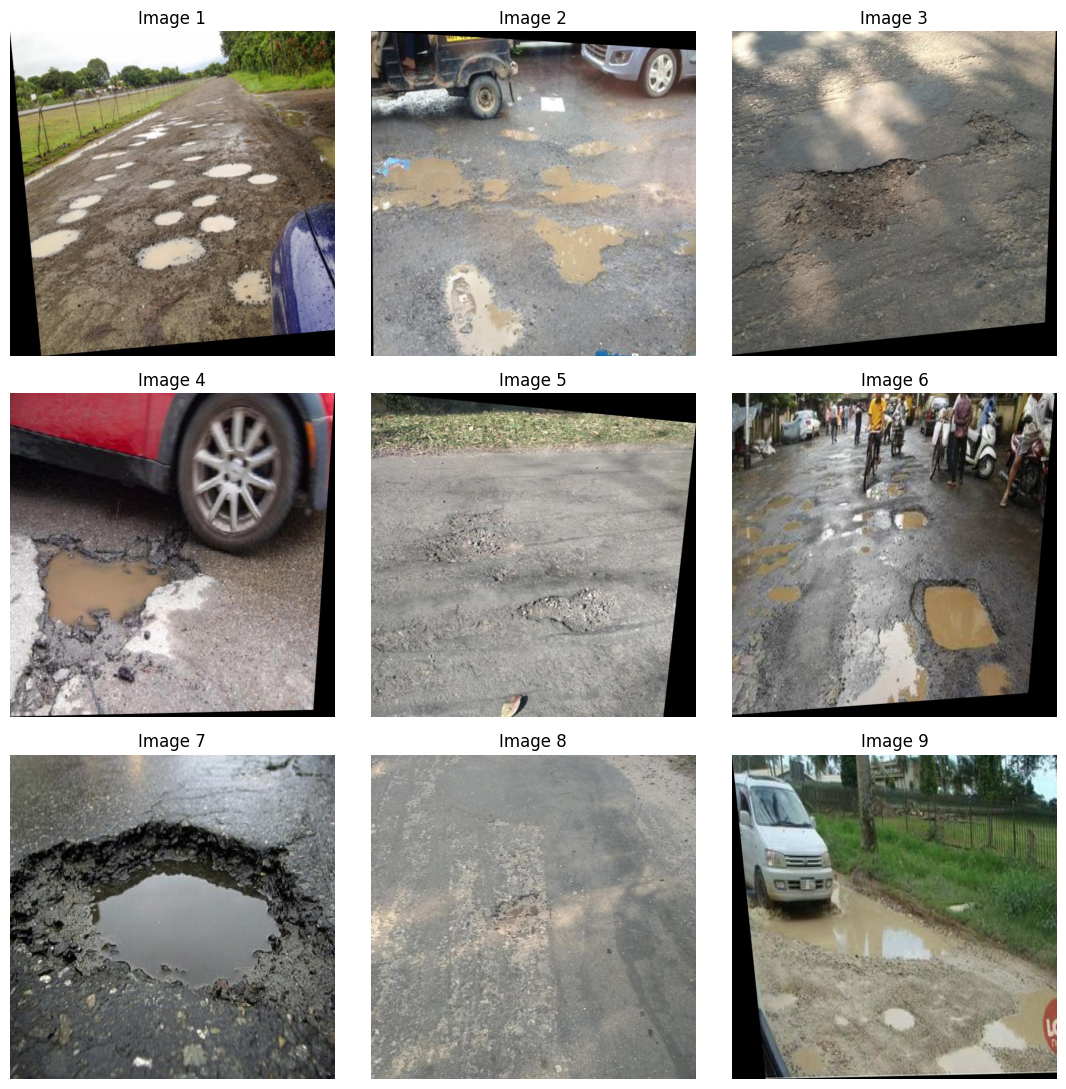

In [26]:
# plot some train images
Image_dir = '/content/Pothole-9/train/images'

num_samples = 9
image_files = os.listdir(Image_dir)

# Randomly select num_samples images
rand_images = random.sample(image_files, num_samples)

fig, axes = plt.subplots(3, 3, figsize=(11, 11))

for i in range(num_samples):
    image = rand_images[i]
    ax = axes[i // 3, i % 3]
    ax.imshow(plt.imread(os.path.join(Image_dir, image)))
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Test some images with a pre-trained YOLOv8 model

In [27]:
test_model = YOLO('yolov8m.pt')

100%|██████████| 49.7M/49.7M [00:00<00:00, 220MB/s]


In [30]:
test_image = '/content/Pothole-9/train/images/img-1002_jpg.rf.1698ab35317f19f82eda136d60a4f8a9.jpg'
test_pred = test_model.predict(source=test_image,imgsz=640)


WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/Pothole-9/train/images/img-1002_jpg.rf.1698ab35317f19f82eda136d60a4f8a9.jpg: 640x640 1 car, 45.7ms
Speed: 15.2ms preprocess, 45.7ms inference, 671.2ms postprocess per image at shape (1, 3, 640, 640)


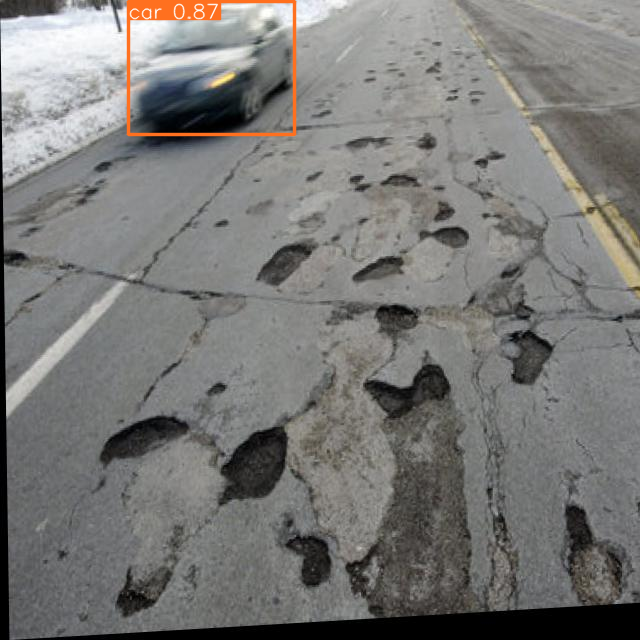

In [33]:
# display the result
plot = test_pred[0].plot()
plot = cv2.cvtColor(plot,cv2.COLOR_BGR2RGB)
display(Image.fromarray(plot))

# Train the YOLOv8 model on our potholes dataset

In [35]:
# get the yolov8m model
model = YOLO('yolov8m.yaml').load('yolov8m.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.conv.Conv             [384

In [36]:
# train the model on train data
train_path = '/content/Pothole-9/data.yaml'
model_train = model.train(data=train_path, epochs=25, imgsz=640, dropout=0.2)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/Pothole-9/data.yaml, epochs=25, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None

100%|██████████| 755k/755k [00:00<00:00, 17.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 87.7MB/s]


AMP: checks passed ✅


train: Scanning /content/Pothole-9/train/labels... 2647 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2647/2647 [00:01<00:00, 2153.73it/s]

train: New cache created: /content/Pothole-9/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Pothole-9/valid/labels... 212 images, 0 backgrounds, 0 corrupt: 100%|██████████| 212/212 [00:00<00:00, 872.96it/s]

val: New cache created: /content/Pothole-9/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)


Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!


25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      7.26G      2.016      2.136      1.933         27        640: 100%|██████████| 166/166 [01:34<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        212        692    0.00242       0.12    0.00145   0.000524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      7.41G      2.053      2.046      1.984         47        640: 100%|██████████| 166/166 [01:27<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

                   all        212        692    0.00633      0.408    0.00467    0.00205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      7.42G      2.033      2.027      1.955         41        640: 100%|██████████| 166/166 [01:26<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        212        692       0.16      0.214     0.0964     0.0324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      7.39G      1.967      1.944      1.884         57        640: 100%|██████████| 166/166 [01:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        212        692      0.534      0.441      0.453        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      7.39G       1.93      1.848      1.864         25        640: 100%|██████████| 166/166 [01:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        212        692       0.59      0.435      0.486      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       7.4G      1.904      1.808      1.835         24        640: 100%|██████████| 166/166 [01:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        212        692      0.559      0.486      0.501      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      7.38G      1.875      1.719      1.807         25        640: 100%|██████████| 166/166 [01:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        212        692      0.603      0.481      0.537      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      7.41G      1.844      1.678      1.808         47        640: 100%|██████████| 166/166 [01:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        212        692      0.647      0.467      0.526      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      7.42G      1.805      1.639      1.763         21        640: 100%|██████████| 166/166 [01:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        212        692      0.665      0.535      0.617      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      7.39G      1.764      1.592      1.743         13        640: 100%|██████████| 166/166 [01:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        212        692       0.69      0.566      0.639      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      7.44G      1.772      1.574      1.722         54        640: 100%|██████████| 166/166 [01:25<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        212        692       0.73      0.552      0.635      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      7.39G      1.747       1.51      1.705         23        640: 100%|██████████| 166/166 [01:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        212        692      0.687      0.542      0.617      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      7.45G      1.703      1.495      1.695         49        640: 100%|██████████| 166/166 [01:26<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        212        692      0.714      0.577      0.651      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      7.45G      1.694      1.459      1.688         42        640: 100%|██████████| 166/166 [01:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        212        692      0.676      0.607       0.65      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      7.42G      1.673      1.455      1.673         28        640: 100%|██████████| 166/166 [01:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        212        692      0.694      0.575      0.642      0.317


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      7.36G      1.689      1.365      1.702         26        640: 100%|██████████| 166/166 [01:27<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        212        692       0.75      0.599      0.652      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      7.44G      1.686      1.315      1.695         44        640: 100%|██████████| 166/166 [01:25<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        212        692      0.698      0.611      0.664      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      7.37G      1.641      1.263       1.68         29        640: 100%|██████████| 166/166 [01:26<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        212        692       0.71      0.623      0.661      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      7.47G      1.616      1.219      1.649         17        640: 100%|██████████| 166/166 [01:25<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        212        692      0.773      0.613      0.698      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      7.35G      1.578      1.183      1.633         14        640: 100%|██████████| 166/166 [01:25<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        212        692      0.736      0.607       0.68      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      7.44G      1.558      1.131      1.614         33        640: 100%|██████████| 166/166 [01:25<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        212        692      0.748      0.622      0.689      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      7.38G       1.52      1.092      1.579         12        640: 100%|██████████| 166/166 [01:25<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        212        692      0.793      0.613      0.708      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      7.39G      1.508      1.059      1.564         16        640: 100%|██████████| 166/166 [01:25<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        212        692      0.744      0.634      0.695       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      7.35G      1.473      1.009      1.546         14        640: 100%|██████████| 166/166 [01:25<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        212        692      0.742      0.618      0.684      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      7.38G      1.465     0.9873      1.542         17        640: 100%|██████████| 166/166 [01:25<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        212        692      0.713      0.663       0.69      0.347



25 epochs completed in 0.666 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


                   all        212        692      0.771      0.613      0.698      0.356
Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train


# Plot Metrics

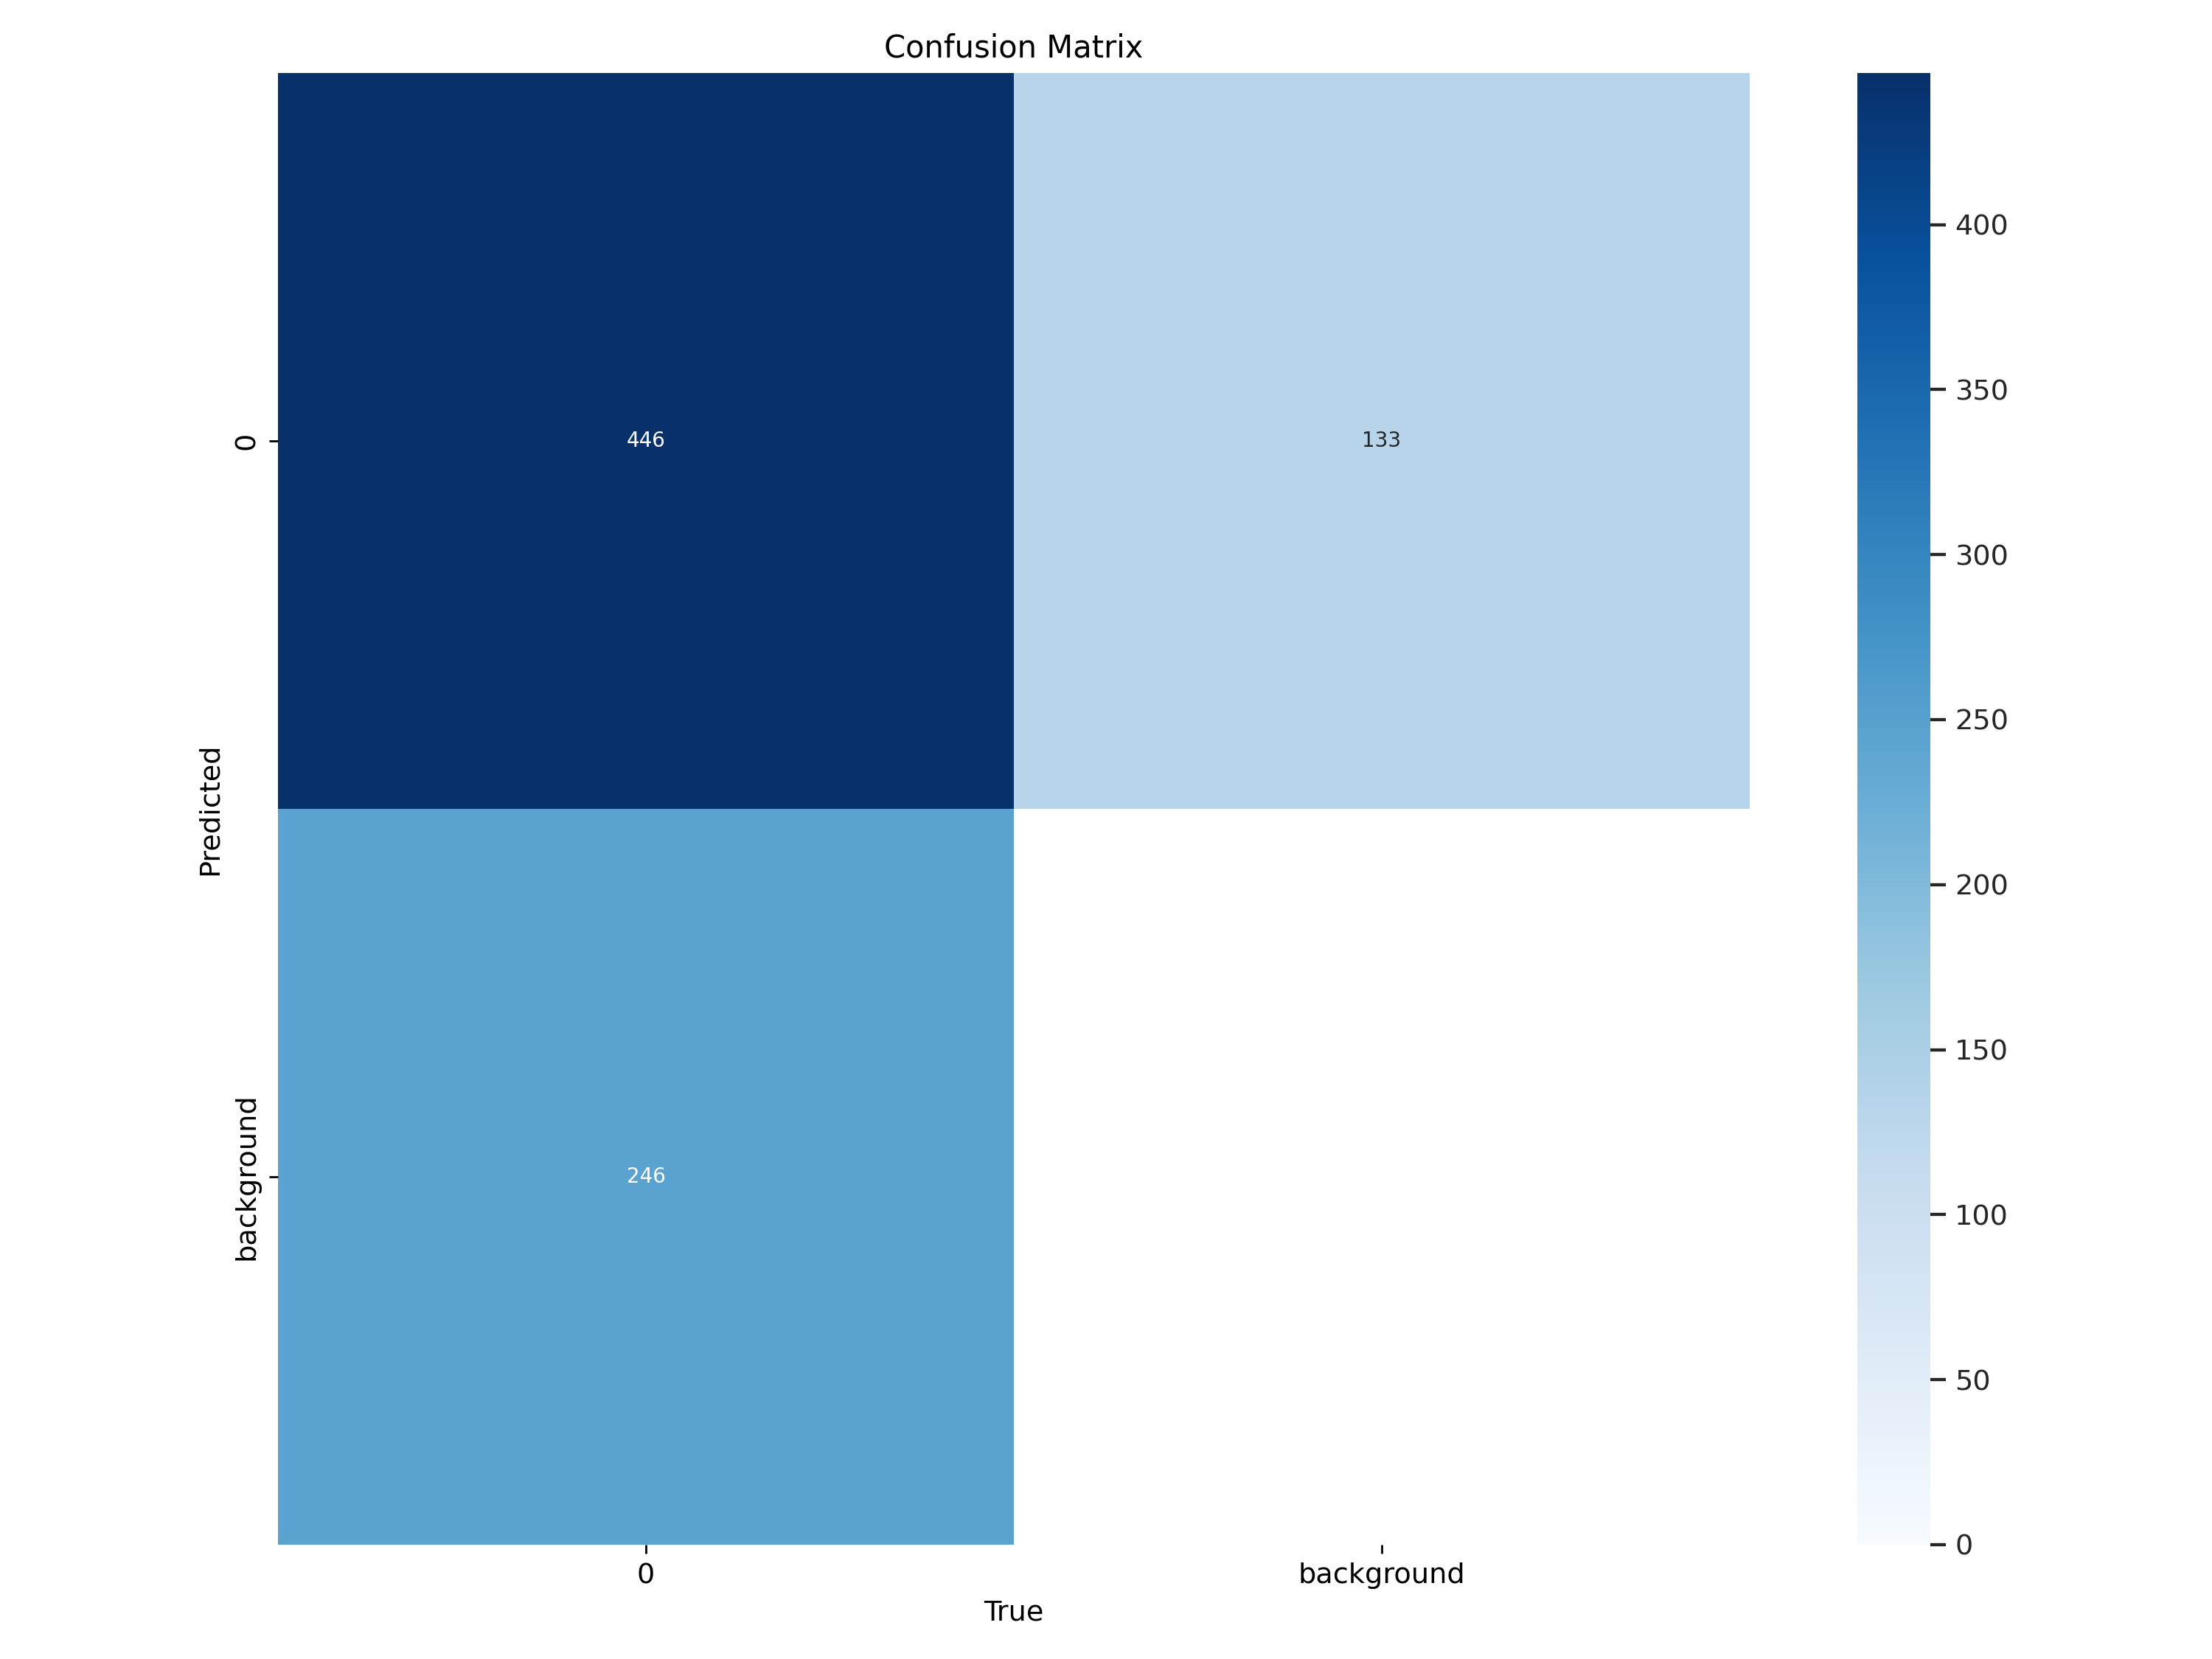

In [40]:
# confusion matrix
Image(filename=f'/content/runs/detect/train/confusion_matrix.png',width=600)

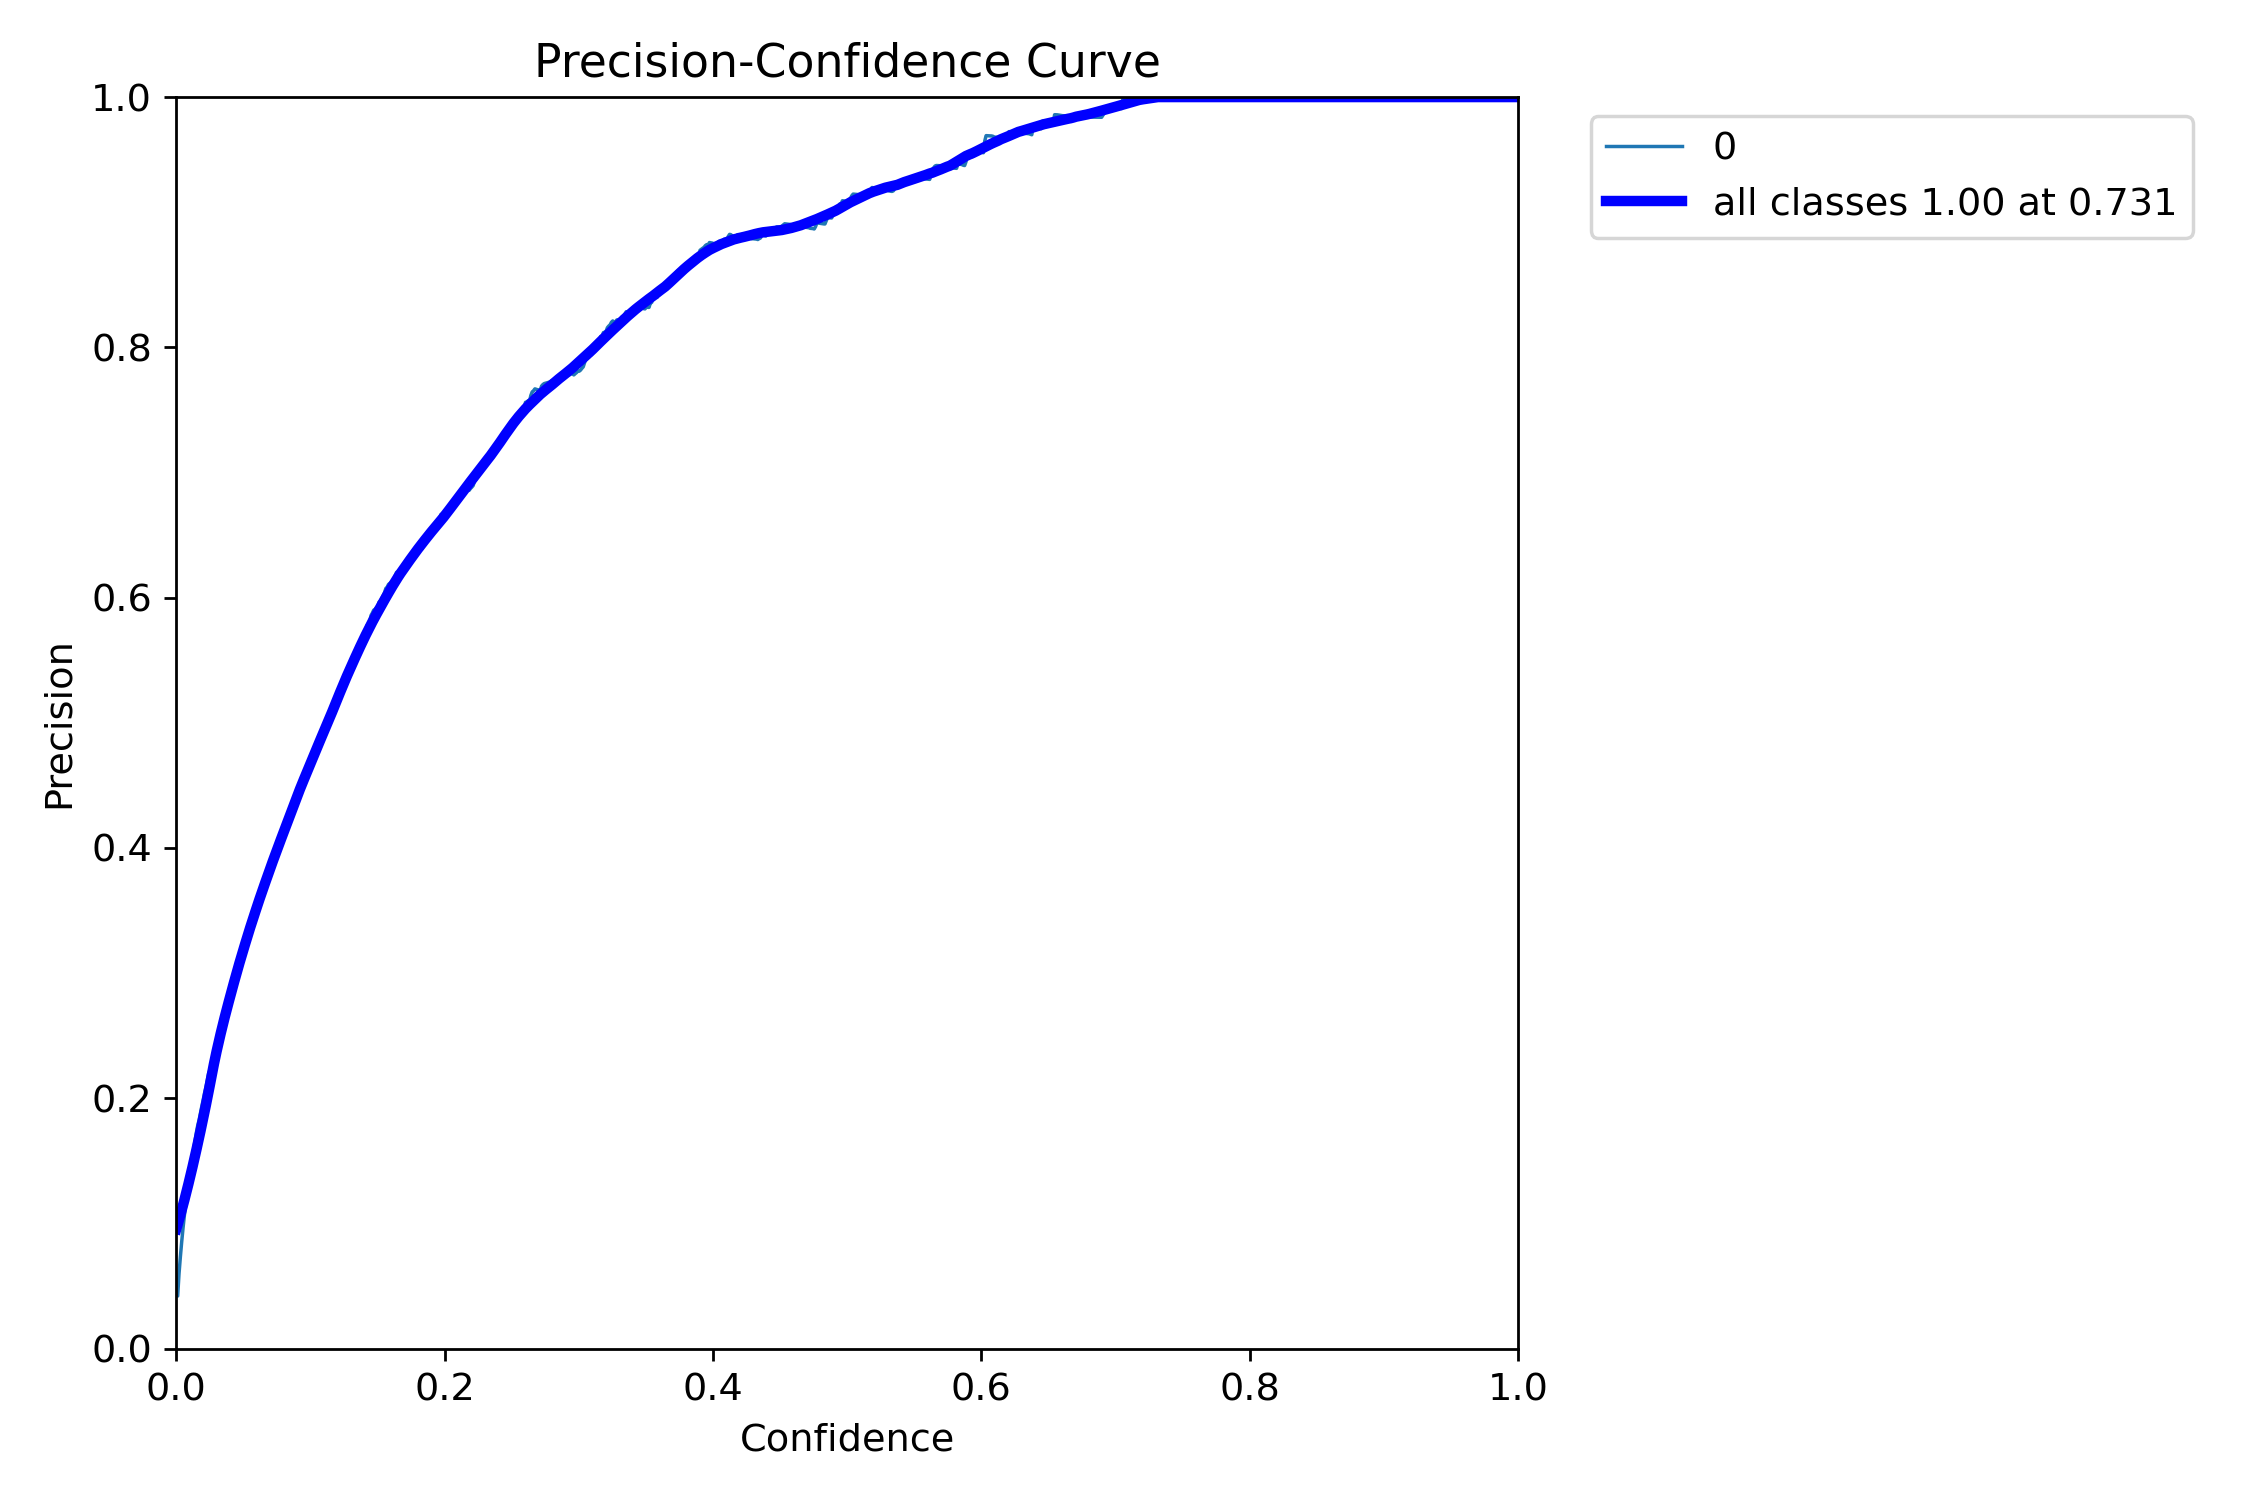

In [41]:
# P curve
Image(filename=f'/content/runs/detect/train/P_curve.png',width=400)

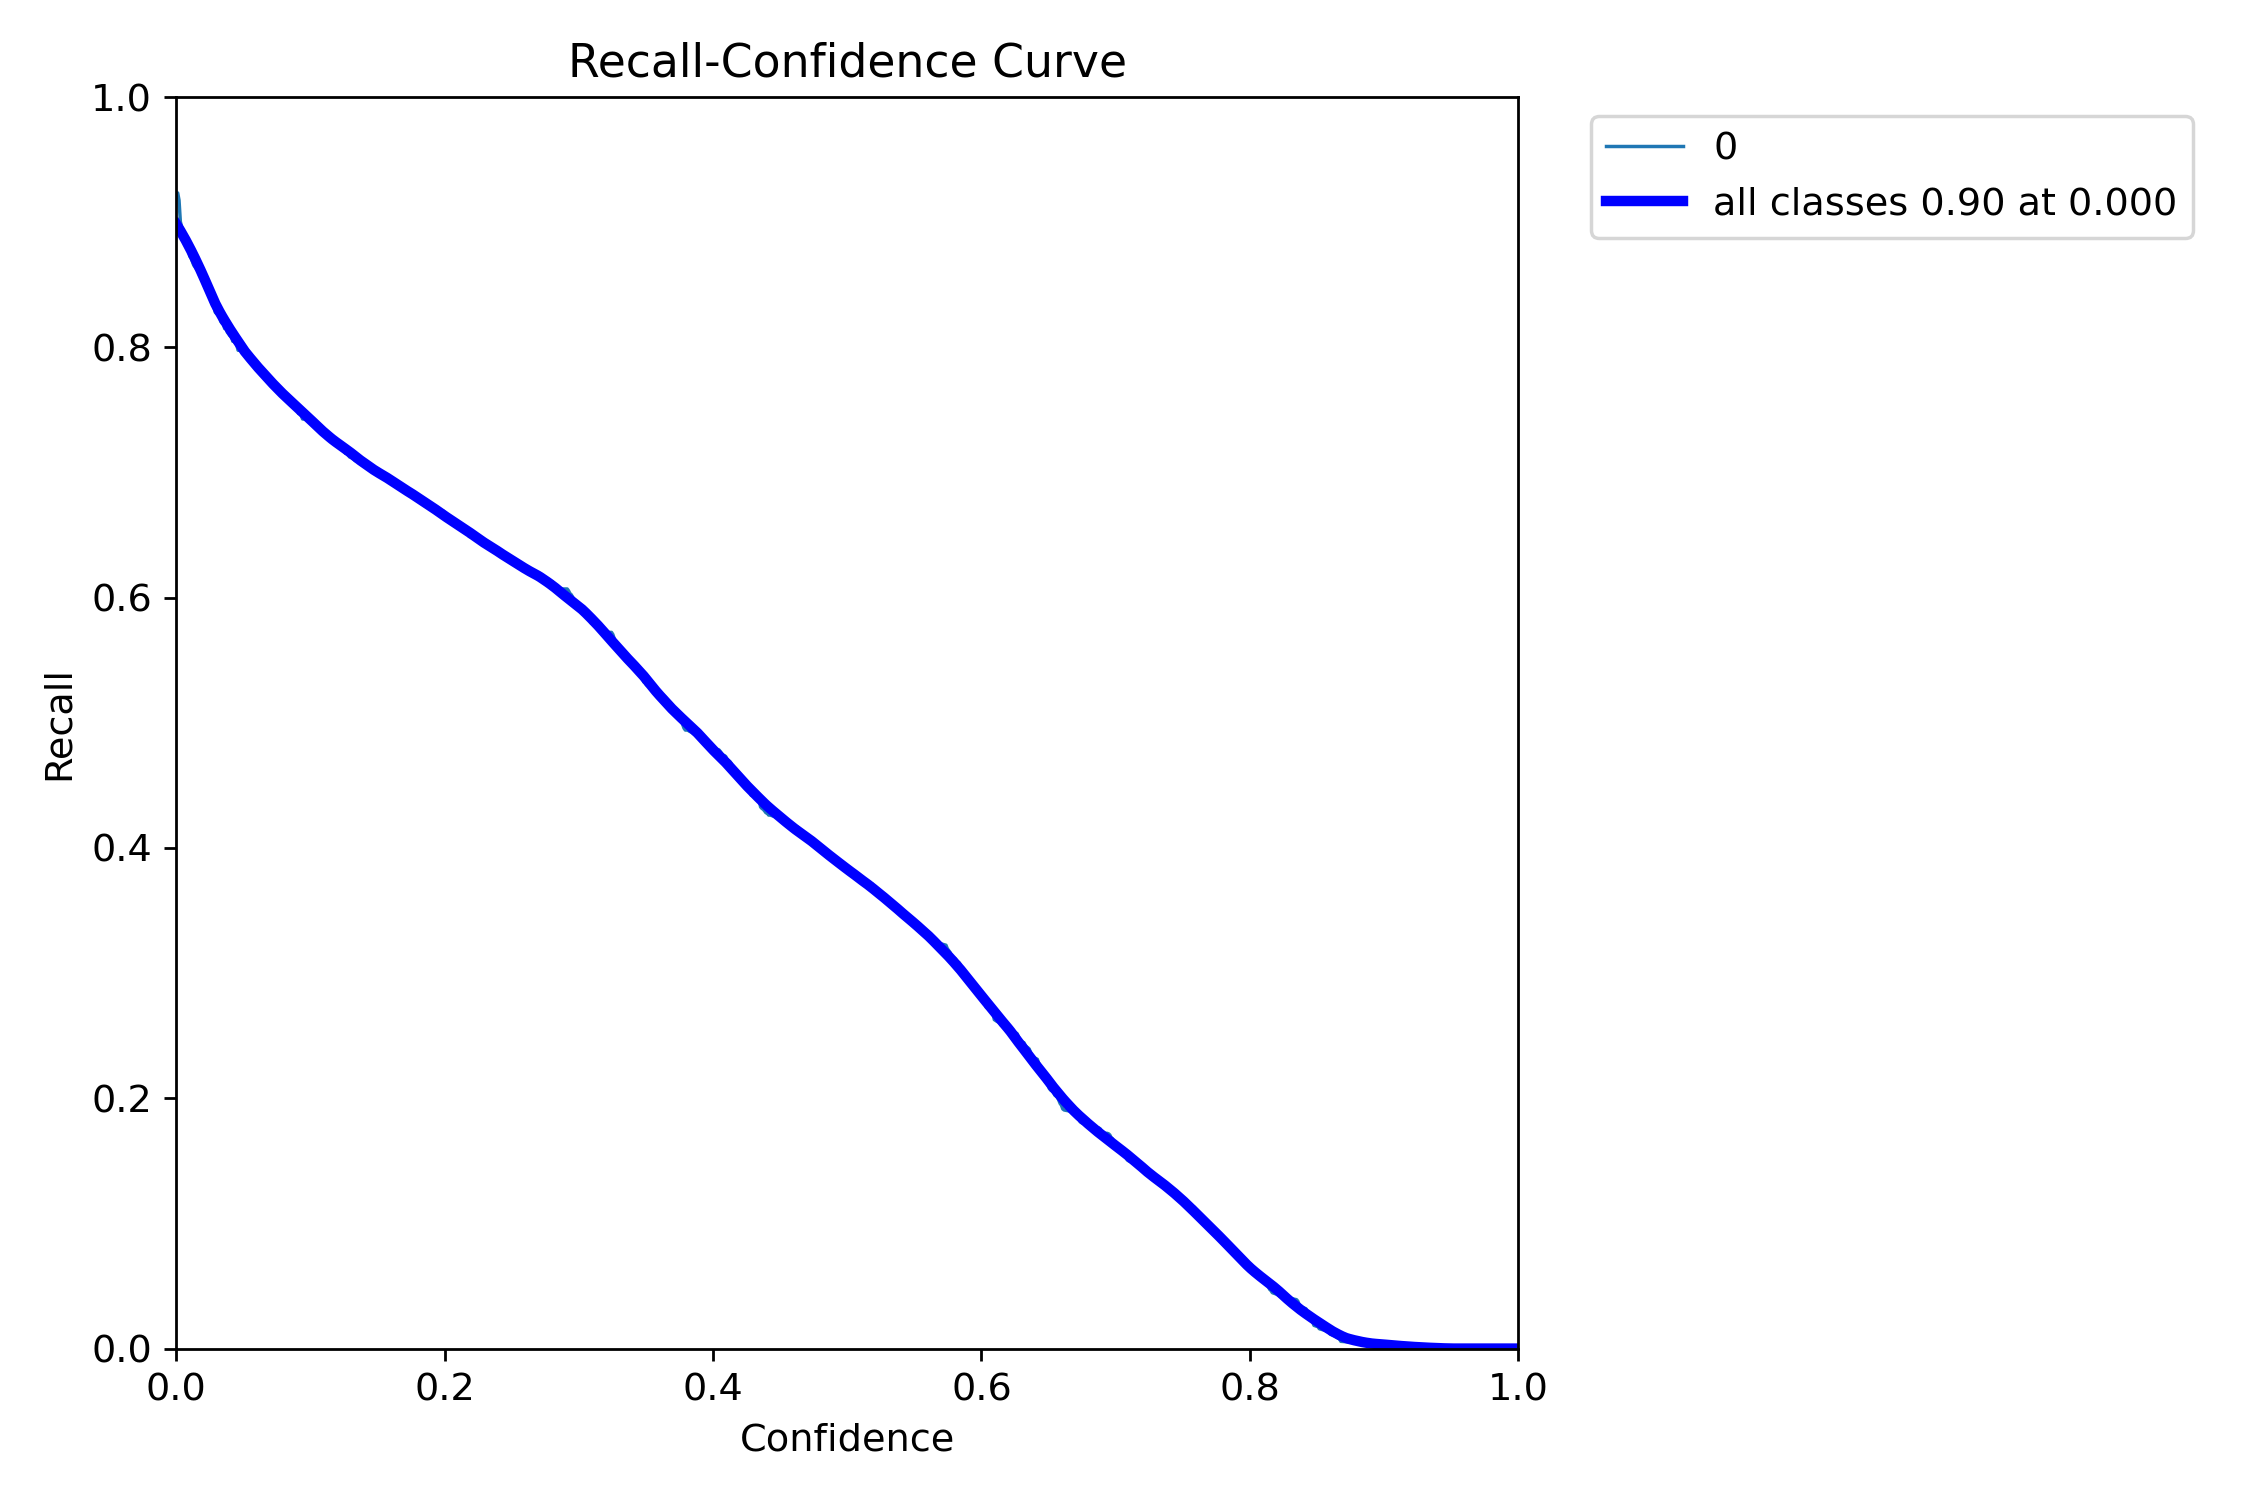

In [42]:
# R curve
Image(filename=f'/content/runs/detect/train/R_curve.png',width=400)

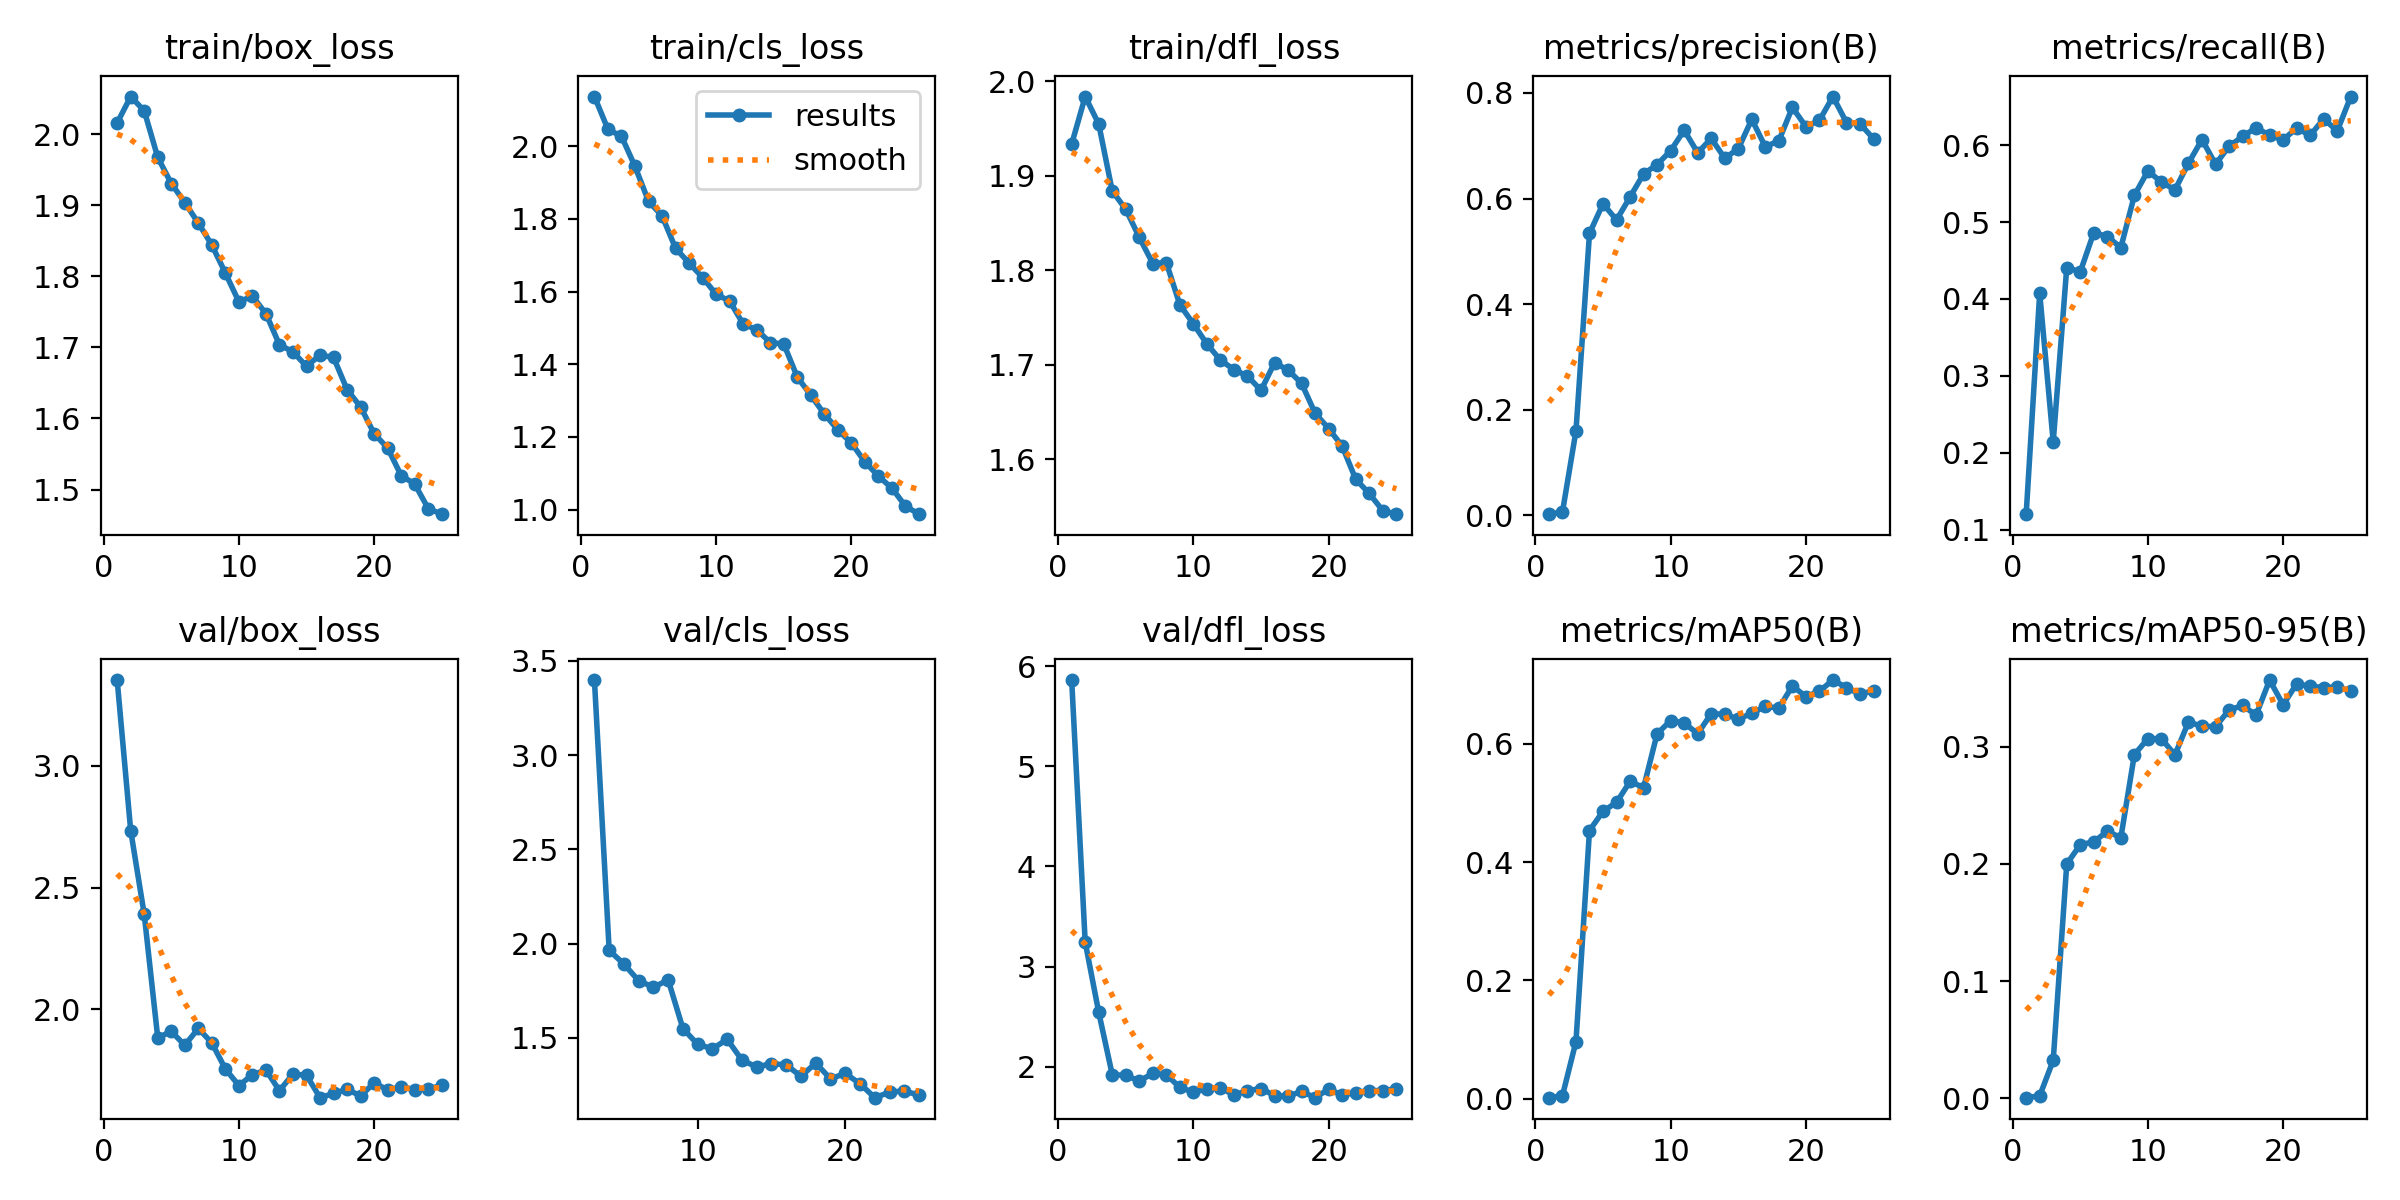

In [52]:
Image(filename='/content/runs/detect/train/results.png',width=600)

# Test the model on test set

In [43]:
best_model = YOLO('/content/runs/detect/train/weights/best.pt')
val_metrics = best_model.val(split='test')

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/Pothole-9/test/labels... 123 images, 0 backgrounds, 0 corrupt: 100%|██████████| 123/123 [00:00<00:00, 334.36it/s]

val: New cache created: /content/Pothole-9/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


                   all        123        374      0.673      0.546      0.583      0.243
Speed: 0.3ms preprocess, 22.7ms inference, 0.0ms loss, 8.0ms postprocess per image
Results saved to runs/detect/val


In [46]:
test_dir = '/content/Pothole-9/test/images'
test_files = [os.path.join(test_dir,filename) for filename in os.listdir(test_dir) if filename.endswith('.jpg')]


In [48]:
best_model.predict(test_files,imgsz=640,save=True)


0: 640x640 12 0s, 1: 640x640 1 0, 2: 640x640 8 0s, 3: 640x640 1 0, 4: 640x640 2 0s, 5: 640x640 1 0, 6: 640x640 1 0, 7: 640x640 1 0, 8: 640x640 1 0, 9: 640x640 2 0s, 10: 640x640 1 0, 11: 640x640 2 0s, 12: 640x640 1 0, 13: 640x640 2 0s, 14: 640x640 1 0, 15: 640x640 2 0s, 16: 640x640 1 0, 17: 640x640 3 0s, 18: 640x640 2 0s, 19: 640x640 1 0, 20: 640x640 2 0s, 21: 640x640 3 0s, 22: 640x640 7 0s, 23: 640x640 2 0s, 24: 640x640 3 0s, 25: 640x640 1 0, 26: 640x640 1 0, 27: 640x640 1 0, 28: 640x640 1 0, 29: 640x640 3 0s, 30: 640x640 3 0s, 31: 640x640 4 0s, 32: 640x640 1 0, 33: 640x640 11 0s, 34: 640x640 4 0s, 35: 640x640 1 0, 36: 640x640 2 0s, 37: 640x640 1 0, 38: 640x640 3 0s, 39: 640x640 1 0, 40: 640x640 1 0, 41: 640x640 1 0, 42: 640x640 5 0s, 43: 640x640 3 0s, 44: 640x640 1 0, 45: 640x640 5 0s, 46: 640x640 1 0, 47: 640x640 1 0, 48: 640x640 1 0, 49: 640x640 1 0, 50: 640x640 2 0s, 51: 640x640 3 0s, 52: 640x640 1 0, 53: 640x640 2 0s, 54: 640x640 7 0s, 55: 640x640 7 0s, 56: 640x640 (no detections

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: '0'}
 orig_img: array([[[ 37,  51,  39],
         [ 42,  56,  44],
         [ 58,  67,  57],
         ...,
         [204, 202, 202],
         [210, 205, 206],
         [207, 202, 203]],
 
        [[ 33,  47,  35],
         [ 41,  53,  41],
         [ 55,  64,  54],
         ...,
         [201, 199, 199],
         [206, 201, 202],
         [202, 197, 198]],
 
        [[ 32,  44,  32],
         [ 38,  50,  38],
         [ 50,  59,  49],
         ...,
         [204, 202, 202],
         [206, 201, 202],
         [203, 198, 199]],
 
        ...,
 
        [[151, 160, 170],
         [155, 164, 174],
         [160, 169, 179],
         ...,
         [ 55,  57,  58],
         [ 59,  63,  64],
         [ 66,  70,  71]],
 
        [[158, 167, 177],
         [159, 168, 178],
         [161, 170, 180],
         ...,
         [ 48,  50,  51],
        

# print some predictions

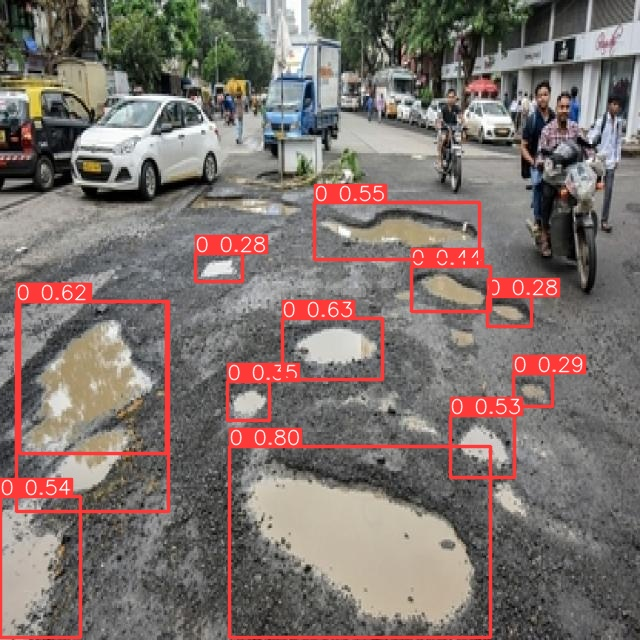

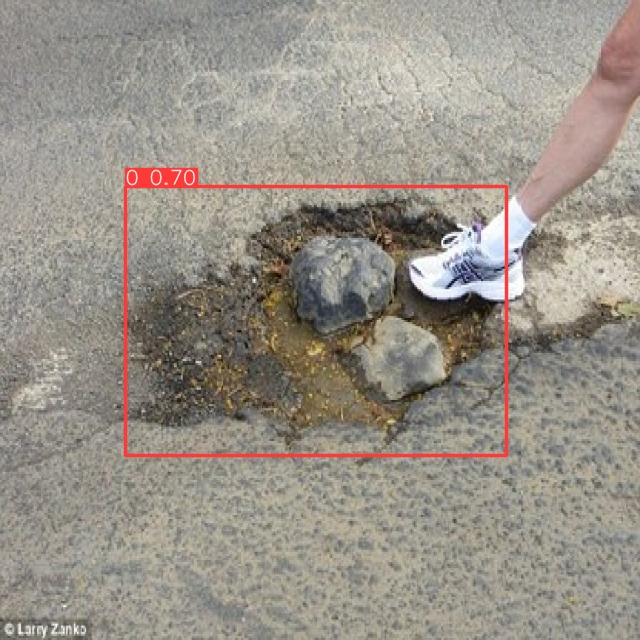

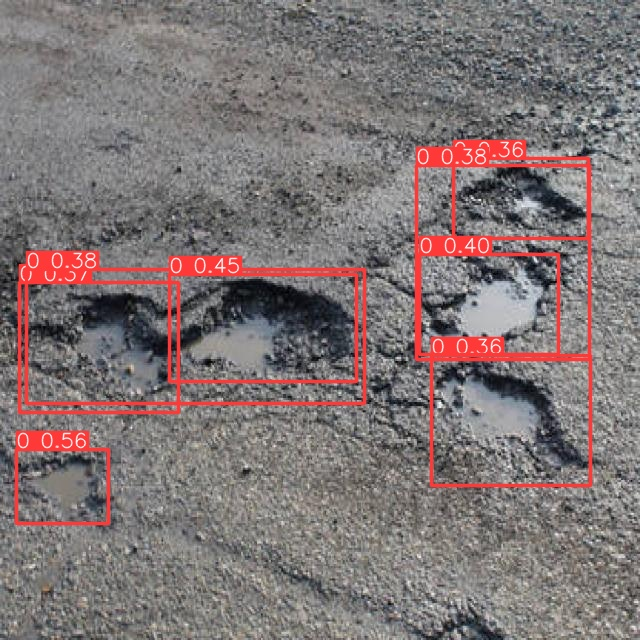

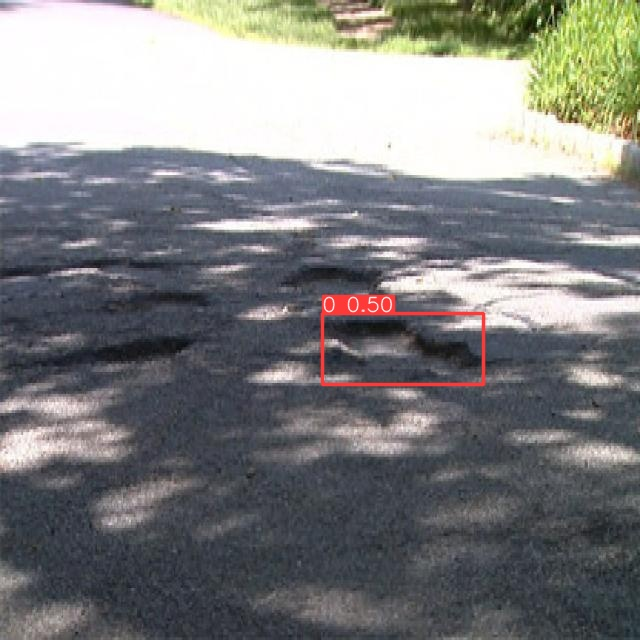

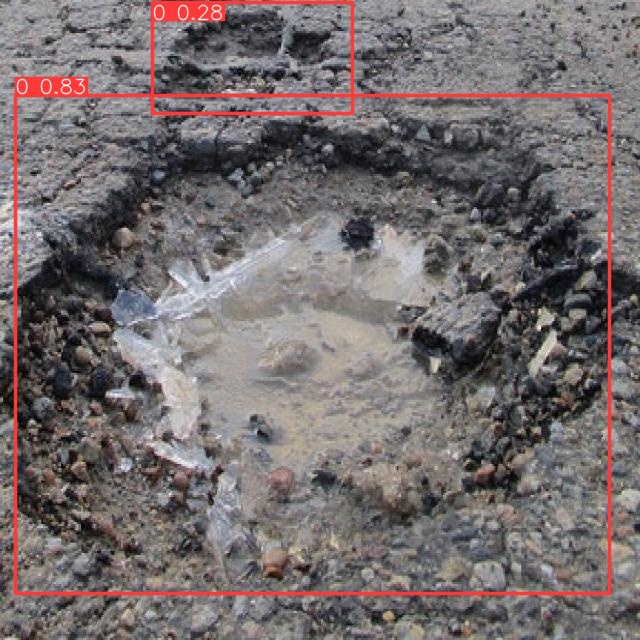

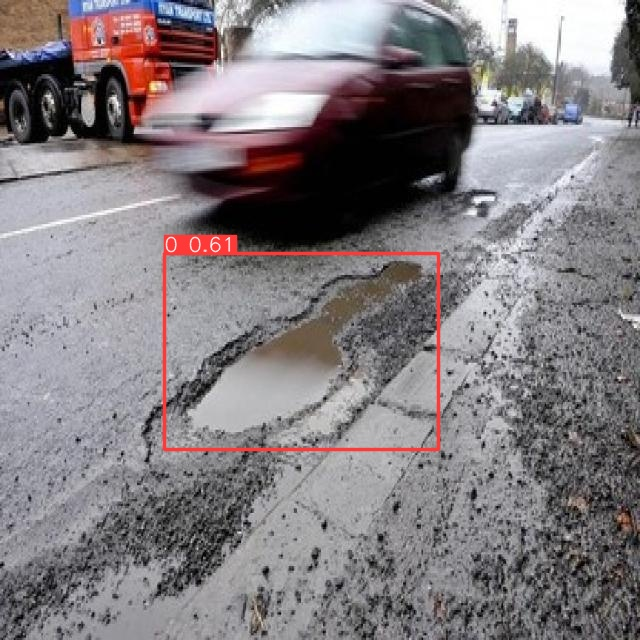

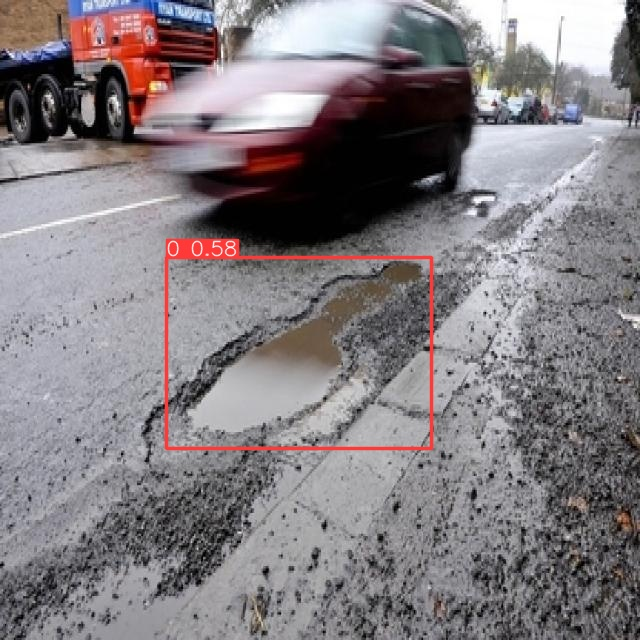

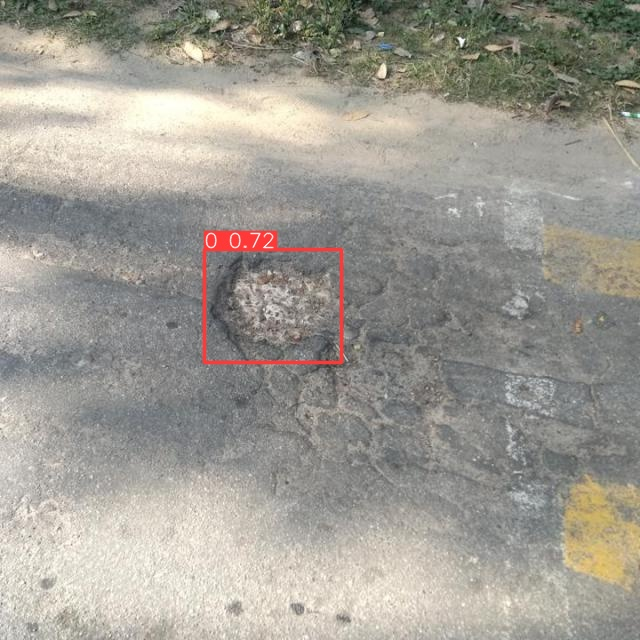

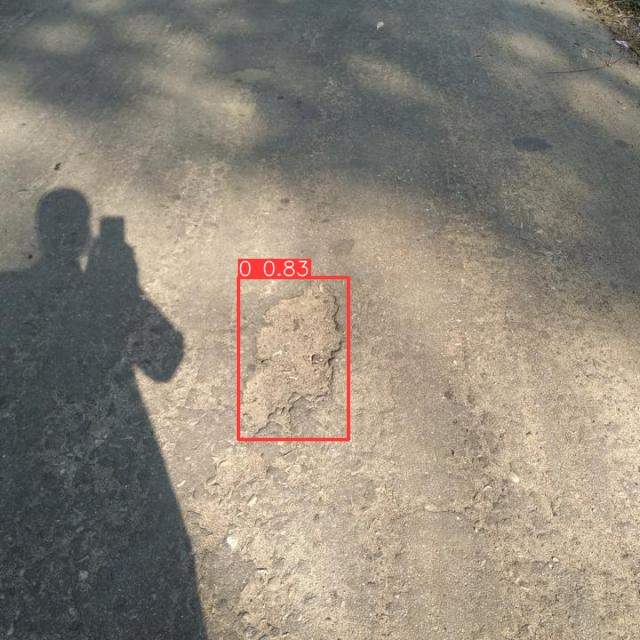

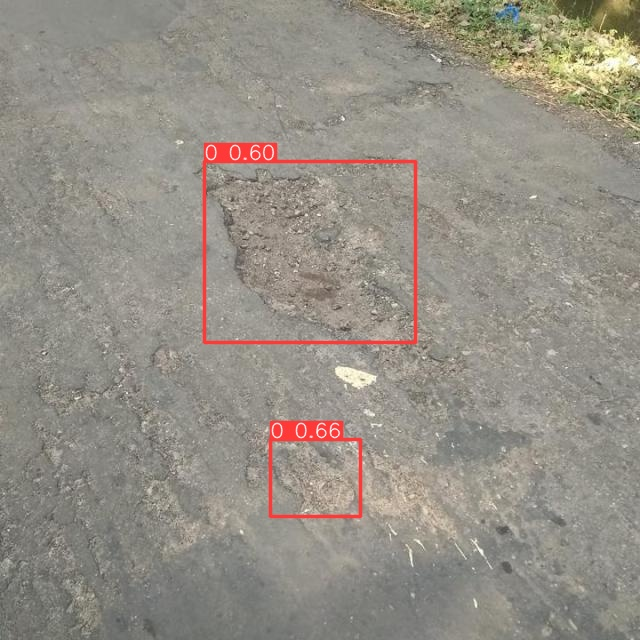

In [53]:
for image_path in glob.glob('/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path))
  print('\n')

# Use of Pothole Detection Model
1. This model can be used in self driving cars to avoid accidents.
2. Can be used by governments to solve the pothole problem around the world
3. Can be used as alert systems in vehicles to avoid accidents.